In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [23]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
measure = Base.classes.measurement
station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [26]:
# Display the row's columns and data in dictionary format
first_row = session.query(measure).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x24ce9b940a0>,
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397'}

In [27]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x24ce987cdf0>,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

# Exploratory Precipitation Analysis

In [30]:
# Find the most recent date in the data set.
# session.query(func.max(Table.column))
max_dt = session.query(func.max(measure.date)).all()
max_dt
max_dt[0][0]

'2017-08-23'

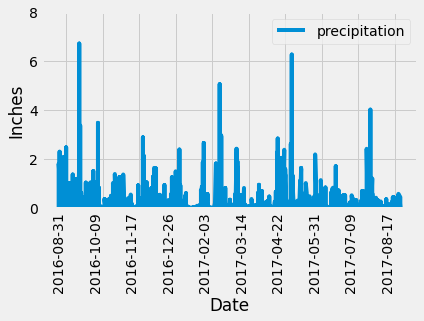

In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# recent_dt = dt.datetime(2017, 8, 23)
recent_dt= dt.datetime.strptime(max_dt[0][0],"%Y-%m-%d").date()
recent_dt
one_year_dt = recent_dt - dt.timedelta(days=365)
one_year_dt

# # Perform a query to retrieve the data and precipitation scores

qry = session.query(measure.date,measure.prcp).filter(measure.date <= recent_dt).\
        filter(measure.date >= one_year_dt)


# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.read_sql_query(qry.statement,engine)
df['date'] = pd.to_datetime(df['date'])
df = df.dropna(how='any')
df = df.rename(columns={'prcp':'precipitation'})
df = df.set_index('date')
df

# Sort the dataframe by date
df1 = df.sort_index()
df1

# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as md

df1.plot(rot=90, ylim=(0,8))

plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(md.DayLocator(interval = 39))

plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation="vertical")
plt.legend(loc='upper right')
plt.savefig("Precipitation analysis.png")
plt.show()



In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
count_stat = session.query(station).count()
count_stat

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stats = session.query(measure.station,func.count(measure.station)).\
group_by(measure.station).order_by(func.count(measure.station).desc()).all()
stats

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stats1 = session.query(measure.station,func.count(measure.station)).\
group_by(measure.station).order_by(func.count(measure.station).desc()).first()
stats1
stats1[0]
session.query(func.min(measure.tobs),
              func.max(measure.tobs),
              func.avg(measure.tobs)).filter(measure.station == stats1[0]).all()

[(54.0, 85.0, 71.66378066378067)]

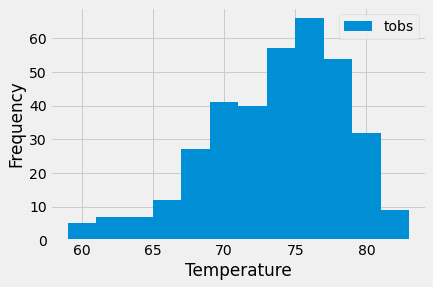

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_dt1 = session.query(func.max(measure.date)).filter(measure.station == stats1[0]).all()
max_dt1

# Calculate the date one year from the last date in data set.('2017-08-18')
recent_dt= dt.datetime.strptime(max_dt1[0][0],"%Y-%m-%d").date()
recent_dt
one_year_dt = recent_dt - dt.timedelta(days=365)
one_year_dt

# Perform a query to retrieve the data and precipitation scores

qry = session.query(measure.tobs).filter(measure.date <= recent_dt).\
        filter(measure.date >= one_year_dt).filter(measure.station == stats1[0])
qry
 

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.read_sql_query(qry.statement,engine)
df = df.dropna(how='any')
df

# bins = compute_histogram_bins(data, 10.0)
# print(bins)
plt.hist(df, bins=12 ,label ='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig("Station analysis.png")
plt.show()

# Close session

In [18]:
# Close Session
session.close()